In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
import networkx as nx
import ast

from nanonets import Simulation
from nanonets.utils import total_harmonic_distortion, BLUE_COLOR, min_max_scale, fft
from matplotlib.animation import FuncAnimation
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from scipy.signal import correlate
from scipy.optimize import curve_fit
from scipy.linalg import eig
from matplotlib.colors import LogNorm

plt.style.use(["science","bright","grid"])
PATH = "/home/jonasmensing/bagheera/data/2_funding_period/dynamic/AC/amp_freq/"
# PATH = "/home/j/j_mens07/bagheera/data/2_funding_period/dynamic/AC/amp_freq/"
# PATH = "/home/j/j_mens07/phd/data/2_funding_period/dynamic/AC/amp_freq/"

### Parameter

In [26]:
AMPLITUDE_LIST  = [0.02,0.03,0.04,0.05,0.06,0.07,0.08]
FREQ_LIST_MHZ   = [0.005,0.01,0.03,0.06,0.12,0.25,0.5,1.,2.,5.,6.,8.,
                   10.,12.,15.,18.,23.,28.,36.,44.,55.,68.,86.,105.,133.,266.,610.,1200.,2400.]
N_PERIODS       = 100
N_SKIP          = 80
SAMPLE_P_PERIOD = 40
N_PARTICLES     = 9
PLOT_AMP_NORM   = Normalize(vmin=1000*AMPLITUDE_LIST[0], vmax=1000*AMPLITUDE_LIST[-1])

### Linear Time Constant and Frequency

In [170]:
topo    = {"Nx": N_PARTICLES,"Ny": N_PARTICLES,
           "e_pos": [[(N_PARTICLES-1)//2, 0],[0, 0],[N_PARTICLES-1, 0],
                     [0, (N_PARTICLES-1)//2],[N_PARTICLES-1, (N_PARTICLES-1)//2],
                     [0, N_PARTICLES-1],[N_PARTICLES-1, N_PARTICLES-1],[(N_PARTICLES-1)//2, N_PARTICLES-1]],
           "electrode_type": ['constant']*8}
sim_c   = Simulation(topo)
sim_c.build_conductance_matrix()
cap_m           = sim_c.get_capacitance_matrix()*1e-18
cap_e           = sim_c.get_electrode_capacitance_matrix().T*1e-18
g_m             = sim_c.get_conductance_matrix()
eigenvalues, _  = eig(g_m[:-8,:-8], cap_m)
real_eigs       = np.real(eigenvalues)
valid_eigs      = real_eigs[real_eigs > 1e-9]
lambda_min      = np.min(valid_eigs)
tau_t           = 1.0 / lambda_min
freq_t          = lambda_min / (2*np.pi)
print(f"f_r = {freq_t*1e-6}")
print(f"tau_0 = {tau_t*1e9}")

f_r = 49.82388564652937
tau_0 = 3.1943502805261783


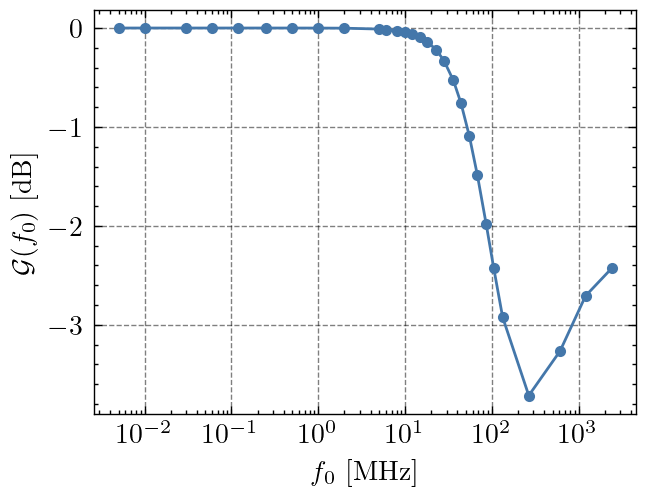

In [167]:
G_II    = g_m[:-8,:-8]
G_IE    = g_m[:-8,-8:]
Phi_E   = np.array([1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],dtype=complex)
J_G     = - (G_IE @ Phi_E)

G_to_drain      = G_IE[:,-1]
C_to_drain      = cap_e[:,-1]

output_currents = []
for f in FREQ_LIST_MHZ:
    omega           = 2 * np.pi * f *1e6
    Y_system        = G_II + 1j * omega * cap_m   
    J_C             = - 1j * omega * (cap_e @ Phi_E)
    J_total         = J_G + J_C
    Phi_I           = np.linalg.solve(Y_system, J_total)
    # Y_to_drain      = G_to_drain + 1j * omega * C_to_drain
    I_out_complex   = np.dot(G_to_drain, Phi_I)
    output_currents.append(np.abs(I_out_complex))

output_currents = np.array(output_currents)
if output_currents[0] == 0:
    ref_val = np.max(output_currents)
else:
    ref_val = output_currents[0]
    
gains_db = 20 * np.log10(output_currents / ref_val)

fig, ax = plt.subplots(dpi=200)
ax.plot(FREQ_LIST_MHZ, gains_db, '.-')
ax.set_xscale('log')
_ = ax.set_xlabel("$f_0$ [MHz]")
_ = ax.set_ylabel("$\mathcal{G}(f_0)$ [dB]")

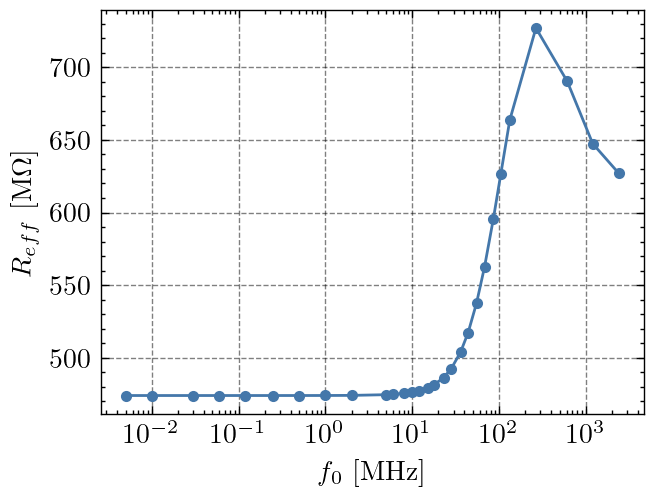

In [172]:
R_eff   = np.abs(Phi_E[0])/output_currents
fig, ax = plt.subplots(dpi=200)
ax.plot(FREQ_LIST_MHZ, R_eff*1e-6, '.-')
ax.set_xscale('log')
_ = ax.set_xlabel("$f_0$ [MHz]")
_ = ax.set_ylabel("$R_{eff}$ [M$\Omega$]")
fig.savefig(f"plots/png/Nx={N_PARTICLES}_Ny={N_PARTICLES}_Reff_vs_f0.png", transparent=False)

### Load Data

In [ ]:
e_type  = 'constant'
dts     = {freq : 1/(40 * freq * 1e6) for freq in FREQ_LIST_MHZ}
N_steps = {freq : int(np.ceil((N_PERIODS / (freq * 1e6)) / dts[freq])) for freq in FREQ_LIST_MHZ}
time    = {freq : dts[freq]*np.arange(N_steps[freq]) for freq in FREQ_LIST_MHZ}
data    = {amp : {freq : pd.read_csv(f"{PATH}Nx={N_PARTICLES}_Ny={N_PARTICLES}_Ne=8_{freq:.3f}_{amp:.3f}_constant.csv")
                  for freq in FREQ_LIST_MHZ} for amp in AMPLITUDE_LIST}
state   = {amp : {freq : pd.read_csv(f"{PATH}mean_state_Nx={N_PARTICLES}_Ny={N_PARTICLES}_Ne=8_{freq:.3f}_{amp:.3f}_constant.csv")
                  for freq in FREQ_LIST_MHZ} for amp in AMPLITUDE_LIST}
x = {amp : {freq : data[amp][freq]['E0'].values[N_SKIP*SAMPLE_P_PERIOD:].copy() for freq in FREQ_LIST_MHZ} for amp in AMPLITUDE_LIST}
y = {amp : {freq : data[amp][freq]['Observable'].values[N_SKIP*SAMPLE_P_PERIOD:].copy() for freq in FREQ_LIST_MHZ} for amp in AMPLITUDE_LIST}
p = {amp : {freq : np.mean(state[amp][freq].iloc[:,8:].values, axis=1)[N_SKIP*SAMPLE_P_PERIOD:].copy() for freq in FREQ_LIST_MHZ} for amp in AMPLITUDE_LIST}

### Gain Curves

In [191]:
def gain_and_phase_current(n, N_periods=20):
    """
    Extracts magnitude and phase for the n-th harmonic.
    Assumes simulation contains exactly N_periods of the fundamental.
    """
    mags = {}
    phis = {}
    
    # Pre-calculate window (Blackman has great dynamic range for harmonics)
    # We assume all time series have the same length for a given f0? 
    # If length varies by freq, we must move this inside the loop.
    
    for amp in AMPLITUDE_LIST:
        mag_list = []
        phi_list = []
        
        for freq in FREQ_LIST_MHZ:
            # y_val = p[amp][freq]
            y_val = y[amp][freq]
            N_samples = len(y_val)
            
            # 1. Apply Window to suppress leakage from n=1 into n=11
            window = np.blackman(N_samples)
            y_windowed = y_val * window
            
            # Window Coherent Gain Correction (important for correct amplitude!)
            # For Blackman, this factor is approx 2.38, but calculating it is safer.
            w_gain = np.sum(window) / N_samples
            
            # 2. Compute FFT once
            fft_vals = np.fft.rfft(y_windowed)
            
            # 3. Find Exact Index
            # Since T_run = N_periods / f0, the bin spacing is f0 / N_periods.
            # The n-th harmonic is at n * f0.
            # Therefore, the index is exactly: n * N_periods
            k = n * N_periods
            
            # Safety check: ensure k is within the FFT array
            if k < len(fft_vals):
                Z_k = fft_vals[k]
                
                # 4. Magnitude (Scaled and Corrected)
                # Mult by 2 for one-sided, divide by N, divide by window gain
                amplitude = (np.abs(Z_k) * 2 / N_samples) / w_gain
                mag_list.append(amplitude)
                
                # 5. Phase
                phi_list.append(np.angle(Z_k))
            else:
                # Harmonic is beyond the Nyquist frequency
                mag_list.append(np.nan)
                phi_list.append(np.nan)

        mags[amp] = np.array(mag_list)
        phis[amp] = np.array(phi_list)
        
    return mags, phis

def gain_and_phase_potential(n, N_periods=20):
    """
    Extracts magnitude and phase for the n-th harmonic.
    Assumes simulation contains exactly N_periods of the fundamental.
    """
    mags = {}
    phis = {}
    
    # Pre-calculate window (Blackman has great dynamic range for harmonics)
    # We assume all time series have the same length for a given f0? 
    # If length varies by freq, we must move this inside the loop.
    
    for amp in AMPLITUDE_LIST:
        mag_list = []
        phi_list = []
        
        for freq in FREQ_LIST_MHZ:
            y_val = p[amp][freq]
            # y_val = y[amp][freq]
            N_samples = len(y_val)
            
            # 1. Apply Window to suppress leakage from n=1 into n=11
            window = np.blackman(N_samples)
            y_windowed = y_val * window
            
            # Window Coherent Gain Correction (important for correct amplitude!)
            # For Blackman, this factor is approx 2.38, but calculating it is safer.
            w_gain = np.sum(window) / N_samples
            
            # 2. Compute FFT once
            fft_vals = np.fft.rfft(y_windowed)
            
            # 3. Find Exact Index
            # Since T_run = N_periods / f0, the bin spacing is f0 / N_periods.
            # The n-th harmonic is at n * f0.
            # Therefore, the index is exactly: n * N_periods
            k = n * N_periods
            
            # Safety check: ensure k is within the FFT array
            if k < len(fft_vals):
                Z_k = fft_vals[k]
                
                # 4. Magnitude (Scaled and Corrected)
                # Mult by 2 for one-sided, divide by N, divide by window gain
                amplitude = (np.abs(Z_k) * 2 / N_samples) / w_gain
                mag_list.append(amplitude)
                
                # 5. Phase
                phi_list.append(np.angle(Z_k))
            else:
                # Harmonic is beyond the Nyquist frequency
                mag_list.append(np.nan)
                phi_list.append(np.nan)

        mags[amp] = np.array(mag_list)
        phis[amp] = np.array(phi_list)
        
    return mags, phis

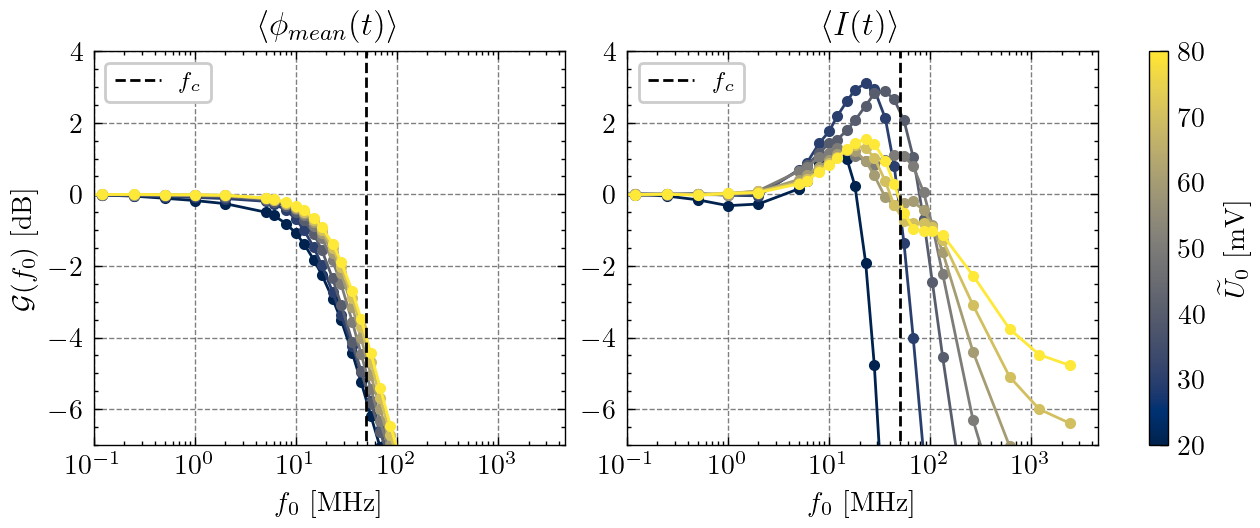

In [208]:
n       = 1
cmap    = plt.get_cmap('cividis')

fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*1.8)
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

# Potential
mags, phis  = gain_and_phase_potential(n)
gain        = {amp : [20*np.log10(mags[amp][i]/mags[amp][0]) for i in range(len(FREQ_LIST_MHZ))] for amp in AMPLITUDE_LIST}

for amp in AMPLITUDE_LIST:
    ax1.plot(FREQ_LIST_MHZ, gain[amp], '.-', color=cmap(PLOT_AMP_NORM(1000*amp)))
ax1.set_xscale('log')
_ = ax1.set_xlabel("$f_0$ [MHz]")
_ = ax1.set_ylabel("$\mathcal{G}(f_0)$ [dB]")
_ = ax1.vlines(freq_t*1e-6, -10, 5, color='black', ls='--', label="$f_c$")
_ = ax1.set_xlim(1e-1)
_ = ax1.set_ylim(-7,4)
_ = ax1.legend(fontsize='small', loc='upper left')
_ = ax1.set_title('$\\langle \phi_{mean}(t) \\rangle$')

# Current
mags, phis  = gain_and_phase_current(n)
gain        = {amp : [20*np.log10(mags[amp][i]/mags[amp][0]) for i in range(len(FREQ_LIST_MHZ))] for amp in AMPLITUDE_LIST}

for amp in AMPLITUDE_LIST:
    ax2.plot(FREQ_LIST_MHZ, gain[amp], '.-', color=cmap(PLOT_AMP_NORM(1000*amp)))
ax2.set_xscale('log')
_ = ax2.set_xlabel("$f_0$ [MHz]")
_ = ax2.vlines(freq_t*1e-6, -10, 5, color='black', ls='--', label="$f_c$")
_ = ax2.set_xlim(1e-1)
_ = ax2.set_ylim(-7,4)
_ = ax2.legend(fontsize='small', loc='upper left')
_ = ax2.set_title('$\\langle I(t) \\rangle$')

sm  = ScalarMappable(cmap=cmap, norm=PLOT_AMP_NORM)
sm.set_array([])
cbar = fig.colorbar(sm, ax=[ax1,ax2])
cbar.set_label("$\\widetilde{U}_0$ [mV]")

fig.savefig(f"plots/pdf/Nx={N_PARTICLES}_Ny={N_PARTICLES}_gain_{n}f0.pdf", transparent=False)
fig.savefig(f"plots/svg/Nx={N_PARTICLES}_Ny={N_PARTICLES}_gain_{n}f0.svg", transparent=True)
fig.savefig(f"plots/png/Nx={N_PARTICLES}_Ny={N_PARTICLES}_gain_{n}f0.png", transparent=False)

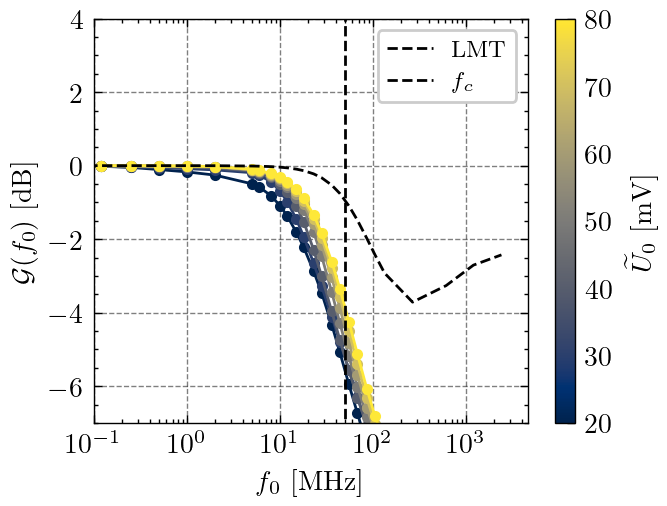

In [ ]:
n           = 1
mags, phis  = gain_and_phase(n)
gain        = {amp : [20*np.log10(mags[amp][i]/mags[amp][0]) for i in range(len(FREQ_LIST_MHZ))] for amp in AMPLITUDE_LIST}
tau_eff     = {amp : [-np.tan(phis[amp][i]/(2*np.pi*FREQ_LIST_MHZ[i]*1e6)) for i in range(len(FREQ_LIST_MHZ))] for amp in AMPLITUDE_LIST}

cmap    = plt.get_cmap('cividis')
fig, ax = plt.subplots(dpi=200)
for amp in AMPLITUDE_LIST:
    ax.plot(FREQ_LIST_MHZ, gain[amp], '.-', color=cmap(PLOT_AMP_NORM(1000*amp)))
# ax.plot(FREQ_LIST_MHZ, gains_db, color='black', ls='--', label='LMT')
ax.set_xscale('log')
_ = ax.set_xlabel("$f_0$ [MHz]")
_ = ax.set_ylabel("$\mathcal{G}(f_0)$ [dB]")
_ = ax.vlines(freq_t*1e-6, -10, 5, color='black', ls='--', label="$f_c$")
_ = ax.set_xlim(1e-1)
_ = ax.set_ylim(-7,4)
_ = ax.legend(fontsize='small')

sm  = ScalarMappable(cmap=cmap, norm=PLOT_AMP_NORM)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$\\widetilde{U}_0$ [mV]")
fig.savefig(f"plots/pdf/Nx={N_PARTICLES}_Ny={N_PARTICLES}_gain_{n}f0.pdf", transparent=False)
fig.savefig(f"plots/svg/Nx={N_PARTICLES}_Ny={N_PARTICLES}_gain_{n}f0.svg", transparent=True)
fig.savefig(f"plots/png/Nx={N_PARTICLES}_Ny={N_PARTICLES}_gain_{n}f0.png", transparent=False)

In [64]:
n_vals      = [1,3,5,7,9,11]
f_max_vals  = np.zeros(shape=(len(AMPLITUDE_LIST),len(n_vals)))
for i, n in enumerate(n_vals):
    mags, phis  = gain_and_phase(n)
    gain        = {amp : [20*np.log10(mags[amp][i]/mags[amp][0]) for i in range(len(FREQ_LIST_MHZ))] for amp in AMPLITUDE_LIST}
    for j, amp in enumerate(AMPLITUDE_LIST):
        val     = gain[amp]
        idx_max = np.argmax(val)
        f_max   = FREQ_LIST_MHZ[idx_max]
        f_max_vals[j,i] = f_max
f_max_vals = pd.DataFrame(f_max_vals,index=np.array(AMPLITUDE_LIST)*1000, columns=n_vals)

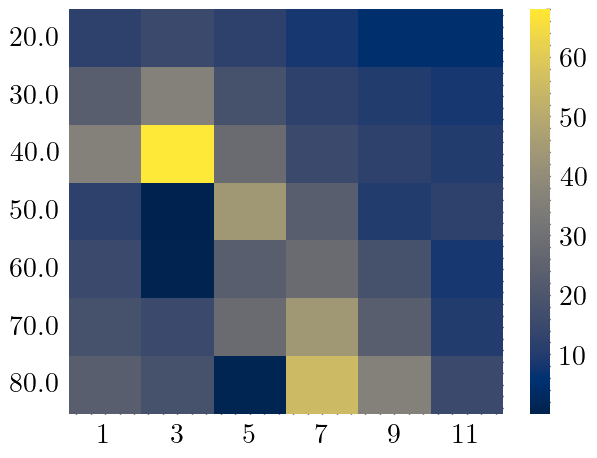

In [69]:
fig, ax = plt.subplots(dpi=200)
ax      = sns.heatmap(f_max_vals, cmap='cividis', ax=ax)
_       = plt.yticks(rotation=0)

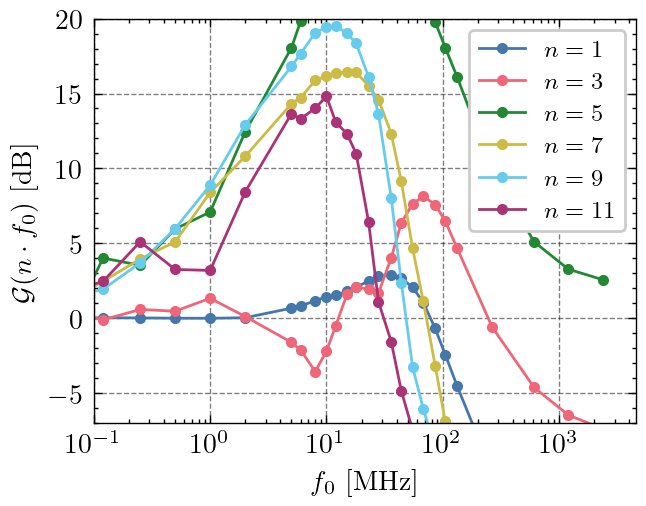

In [47]:
amp     = 0.04
cmap    = plt.get_cmap('cividis')
fig, ax = plt.subplots(dpi=200)
vals    = []
for n in [1,3,5,7,9,11]:
    mags, phis  = gain_and_phase(n)
    gain        = {amp : [20*np.log10(mags[amp][i]/mags[amp][0]) for i in range(len(FREQ_LIST_MHZ))] for amp in AMPLITUDE_LIST}
    vals.append(gain[amp])
    ax.plot(FREQ_LIST_MHZ, gain[amp], '.-', label=f'$n = {n}$')

ax.set_xscale('log')
_ = ax.set_xlabel("$f_0$ [MHz]")
_ = ax.set_ylabel("$\mathcal{G}(n \cdot f_0)$ [dB]")
_ = ax.set_xlim(1e-1)
_ = ax.set_ylim(-7,20)
_ = ax.legend(fontsize='small', ncol=1)
# fig.savefig(f"plots/pdf/Nx={N_PARTICLES}_Ny={N_PARTICLES}_gain_vs_n.pdf", transparent=False)
# fig.savefig(f"plots/svg/Nx={N_PARTICLES}_Ny={N_PARTICLES}_gain_vs_n.svg", transparent=True)
# fig.savefig(f"plots/png/Nx={N_PARTICLES}_Ny={N_PARTICLES}_gain_vs_n.png", transparent=False)

### Output Response

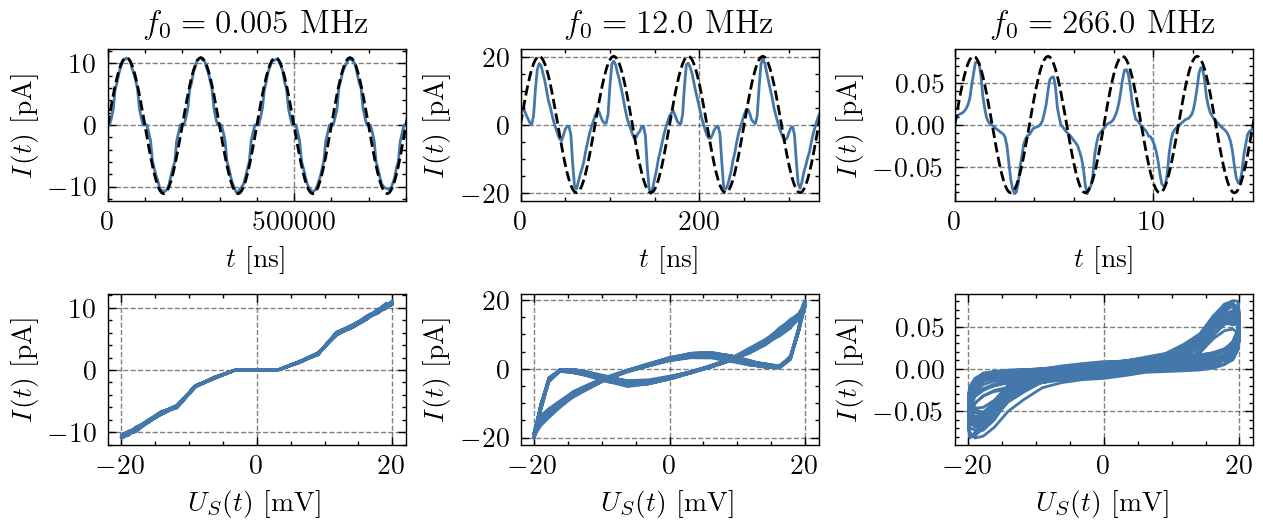

In [42]:
f0s = [0.005,12.0,266.]
amp = 0.02
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*1.8)
for i, freq in enumerate(f0s):
    ax      = fig.add_subplot(2,3,i+1)
    t_val   = time[freq].copy()[:-(N_SKIP*SAMPLE_P_PERIOD)-1]
    x_val   = x[amp][freq].copy()
    y_val   = y[amp][freq].copy()*1e-6
    _       = ax.plot(t_val*1e9, y_val)
    _       = ax.plot(t_val*1e9, (y_val.max() - y_val.min())*(x_val-x_val.min()) / (x_val.max() - x_val.min()) - y_val.max(), color='black', ls='--')
    _       = ax.set_xlim(0,t_val[SAMPLE_P_PERIOD*4]*1e9)
    # _       = ax.set_ylim(-10,10)
    _       = ax.set_xlabel("$t$ [ns]")
    _       = ax.set_ylabel("$I(t)$ [pA]")
    _       = ax.set_title(f"$f_0 = {freq}$ MHz")
for i, freq in enumerate(f0s):
    ax      = fig.add_subplot(2,3,i+4)
    t_val   = time[freq].copy()[:-(N_SKIP*SAMPLE_P_PERIOD)-1]
    x_val   = x[amp][freq].copy()*1000
    y_val   = y[amp][freq].copy()*1e-6
    _       = ax.plot(x_val, y_val)
    _       = ax.set_xlabel("$U_S(t)$ [mV]")
    _       = ax.set_ylabel("$I(t)$ [pA]")

fig.savefig(f"plots/pdf/output_responses_examples.pdf", transparent=False)
fig.savefig(f"plots/svg/output_responses_examples.svg", transparent=True)
fig.savefig(f"plots/png/output_responses_examples.png", transparent=False)

In [295]:
th_val  = -3
cut_d   = {}
n_vals  = [1,3,5,7,9]
for amp in [0.02,0.03,0.06,0.07,0.08]:
    cuts = []
    for n in n_vals:
        mags, phis  = gain_and_phase(n)
        gain        = [20*np.log10(mags[amp][i]/mags[amp][0]) for i in range(len(FREQ_LIST_MHZ))]
        for i in range(len(gain)):
            if np.min(gain) > th_val:
                print(f"n={n}: bandwidth too high (never crosses {th_val}dB)")
                continue
            if gain[i] >= th_val > gain[i+1]:
                slope       = (FREQ_LIST_MHZ[i+1] - FREQ_LIST_MHZ[i]) / (gain[i+1] - gain[i])
                f_cross     = FREQ_LIST_MHZ[i] + slope * (th_val - gain[i])
                cutoff      = f_cross
                cuts.append(cutoff)
                break
    cut_d[amp] = cuts

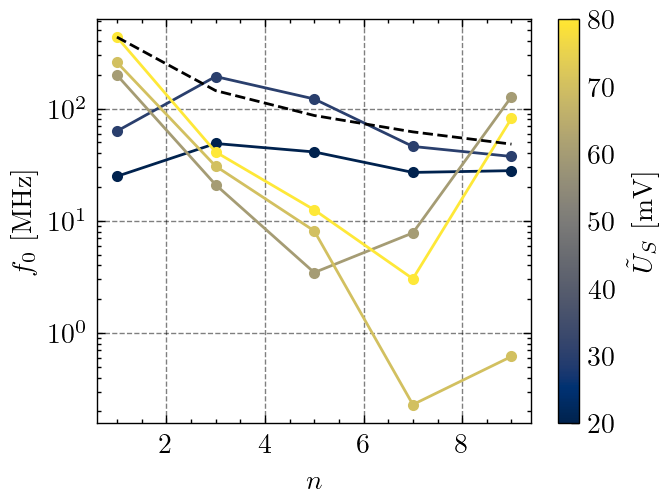

In [296]:
fig, ax = plt.subplots(dpi=200)
for amp in [0.02,0.03,0.06,0.07,0.08]:
    ax.plot(np.array(n_vals), cut_d[amp], color=cmap(norm(1000*amp)), marker='.')
ax.plot(np.array(n_vals), cut_d[amp][0]/np.array(n_vals), color='black', ls='--')
# ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("$n$")
ax.set_ylabel("$f_0$ [MHz]")

sm  = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$\\tilde{U}_S$ [mV]")

# fig.savefig(f"plots/pdf/f0_at_3db.pdf", transparent=False)
# fig.savefig(f"plots/svg/f0_at_3db.svg", transparent=True)
# fig.savefig(f"plots/png/f0_at_3db.png", transparent=False)

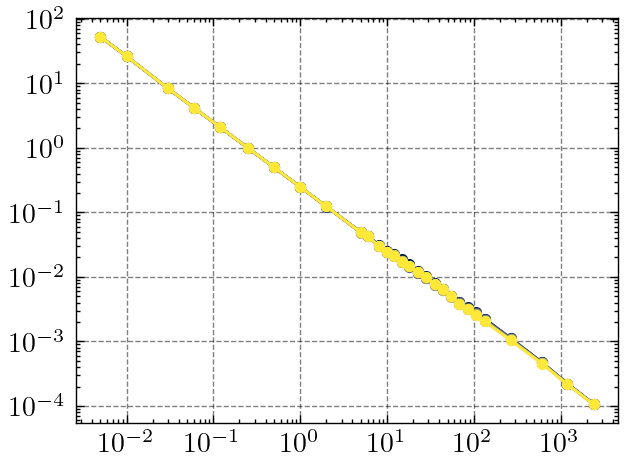

In [98]:
fig, ax = plt.subplots(dpi=200)
for amp in AMPLITUDE_LIST:
    ax.plot(FREQ_LIST_MHZ, np.abs(tau_eff[amp])*1e6, '.-', color=cmap(norm(1000*amp)))
ax.set_xscale('log')
ax.set_yscale('log')